In [2]:
from scipy.stats import zscore, norm, probplot
from loading_data import *
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
normalised_X = np.copy(X)
#transform
normalised_X[:,6] = np.log(1 + X[:,6]) #add 1 because some alcohol values are 0
#normalise
normalised_X = zscore(normalised_X, axis = 0, ddof = 1)

attributeNames_norm = np.copy(attributeNames)
attributeNames_norm[6] = 'log-alc'
attributeNames_norm = ['normalized ' + attribute for attribute in attributeNames_norm]

#Or without the last binary data

Y = np.copy(normalised_X[:,:-1])
N_y, M_y = Y.shape

attributeNames_y = np.copy(attributeNames_norm[:-1])

We plot the histograms before and after the transformations

In [4]:
#First generate N points between 0 and 1 equally distanced

ppoints = np.linspace(0.01,.99, num = N)

#Then we get the quantiles

normal_quantiles = norm.ppf(ppoints) #quantiles

normal_counts, normal_bin_edges = np.histogram(normal_quantiles, bins = 30, density = True)

normal_bin_midpoints = (normal_bin_edges[:-1] + normal_bin_edges[1:]) / 2


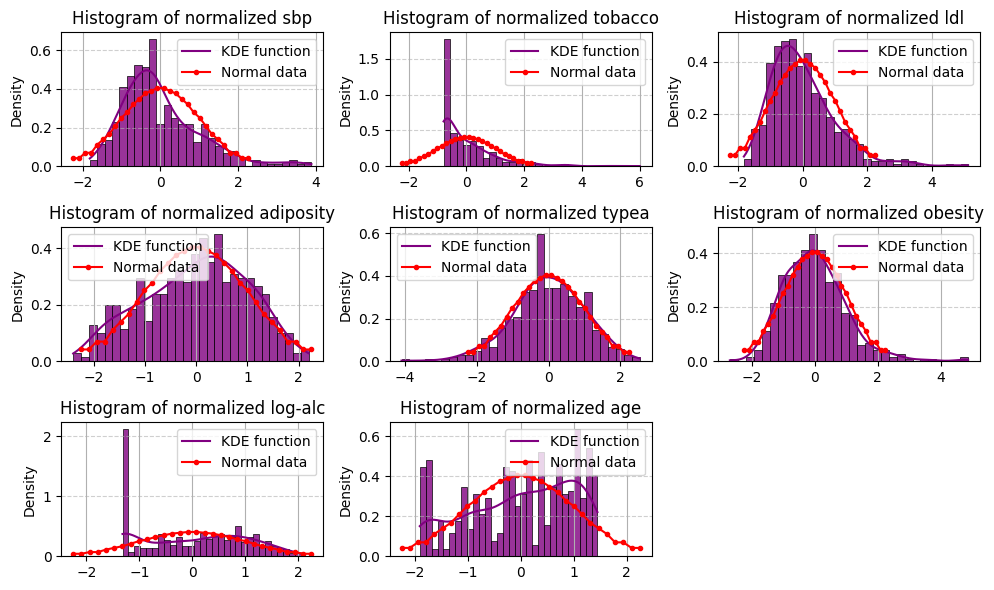

In [5]:
f, axes = plt.subplots(nrows = 3, ncols = 3, figsize = (10,6))
axes = axes.ravel()
for idx, attribute in enumerate(attributeNames_y):
    ax = axes[idx]
    # axes[idx].hist(Y[:,idx], bins = 30)
    #or using seaborn
    sns.histplot(Y[:,idx], bins = 30, ax = ax, kde = True, color = 'purple', stat = 'density', alpha = 0.8)
    ax.lines[-1].set_label('KDE function')
    ax.plot(normal_bin_midpoints, normal_counts, label = 'Normal data', marker = '.', color = 'red')
    ax.grid(True)
    if idx != 3 and idx != 4 :
        ax.legend(loc="upper right")
    else:
        ax.legend(loc='upper left')
    
    ax.set_title(f'Histogram of {attribute}')
    ax.grid(axis='y', linestyle='--', alpha=0.6)

f.delaxes(axes[8])

plt.tight_layout()  # Prevent overlapping

plt.show()

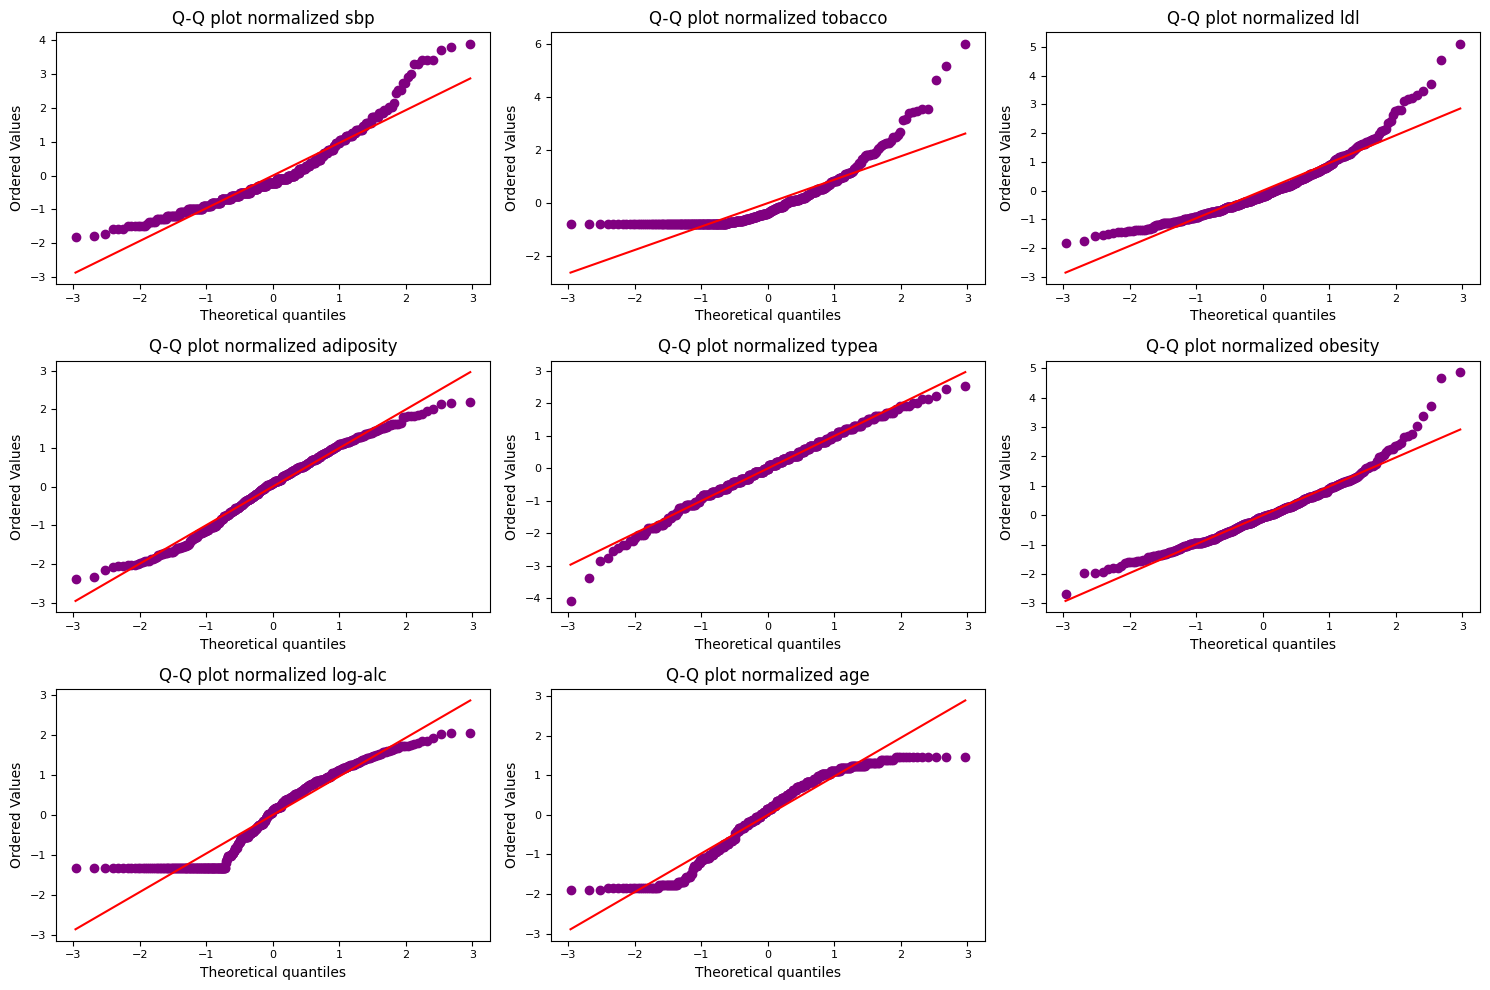

In [6]:
## Q-Q plot : 

f, axes = plt.subplots(nrows = 3, ncols = 3,figsize = (15,10))
axes = axes.ravel()
for i, attribute in enumerate(attributeNames_y):
    ax = axes[i]
    probplot(Y[:,i], plot = ax)
    ax.get_lines()[0].set_color('purple')
    ax.set_title('Q-Q plot ' + attribute)
    ax.tick_params(axis='both', labelsize=8)
f.delaxes(axes[8])
plt.tight_layout()
plt.show()

## Corrolation analysis

In [ ]:
from dtuimldmtools import similarity

#### Heatmap plot


Let's randomly select 100 rows to make the analysis simpler

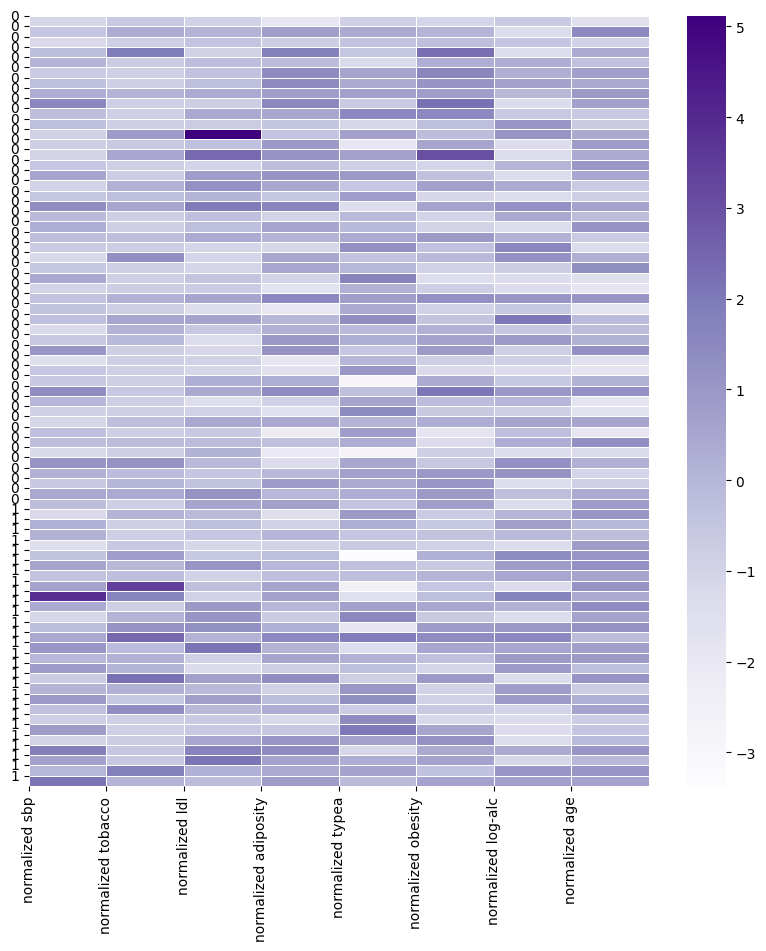

In [8]:
np.random.seed(123) # we seed the random number generator to get the same random sample every time
sample_size = 75
subsample_mask = np.random.choice(N, sample_size, replace=False)
Y_sample = Y[subsample_mask, :]
y_sample = y[subsample_mask]

sorted_indices = np.argsort(y_sample) # sort rows in X acording to whether they are red of white
Y_sorted = Y_sample[sorted_indices]
y_sorted = y_sample[sorted_indices]

plt.figure(figsize = (10,10))
sns.heatmap(Y_sorted, cmap = 'Purples', linewidths=0.5, cbar=True)
plt.xticks(ticks=np.arange(len(attributeNames_y)), labels=attributeNames_y, rotation="vertical")
plt.yticks(ticks=np.arange(sample_size), labels=y_sorted, rotation="horizontal")
plt.show()


In [9]:
#in our sample we see more 'no' reponse to chd rather than 'yes', by curiosity we look at the count of 'yes' in the total data.

count = np.sum(y)
print(count)

#So we see that it accounts for approximatily 1/3 of the data, and therefore realize that our sample is pretty representative of our data.

160


We will try to have a look at all the data, even with the binary data.

#### second heatmap

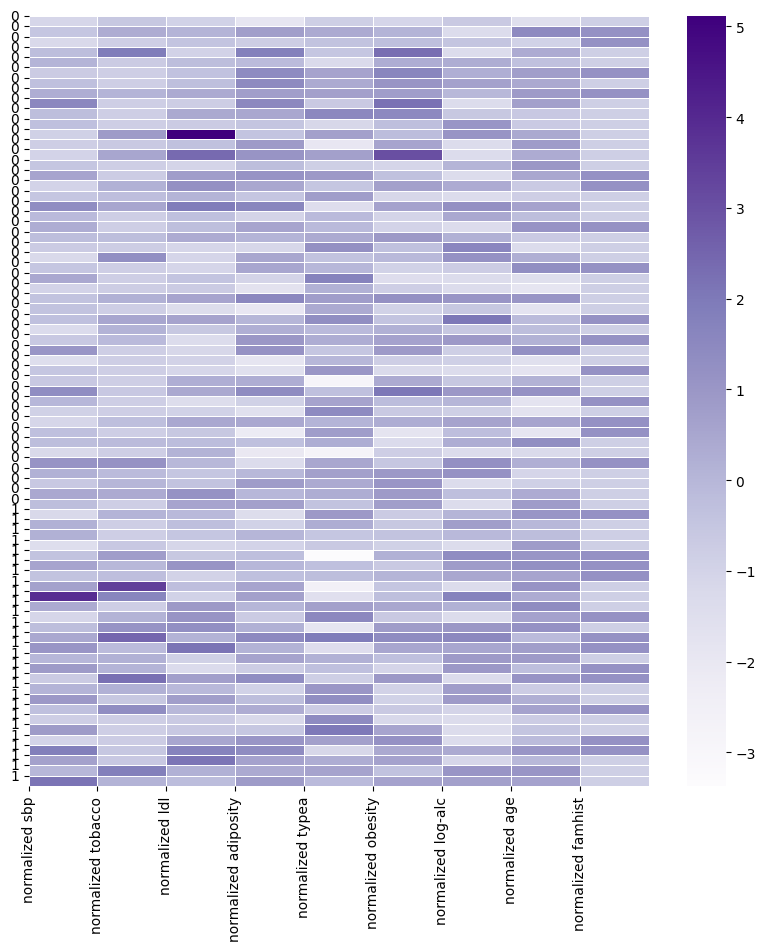

In [10]:
sample_norm_X = normalised_X[subsample_mask, :]
# the y is already taken care of above so we only take care of the X

sorted_norm_X = sample_norm_X[sorted_indices]

plt.figure(figsize = (10,10))
sns.heatmap(sorted_norm_X, cmap = 'Purples', linewidths=0.5, cbar=True)
plt.xticks(ticks=np.arange(len(attributeNames_norm)), labels=attributeNames_norm, rotation="vertical")
plt.yticks(ticks=np.arange(sample_size), labels=y_sorted, rotation="horizontal")
plt.show()


#### Calculate the correlation 

Note that here we use the raw binary data for chd and the transformed (normalised) binary data for the famhist. 
But i think that this does not hurt.

##### Idea : maybe consider another measure of similarity for the correlation between the famhist and the chd variable.

In [11]:
measure = 'correlation'

AttributeCorr = np.zeros((9,9))
ClassCorr = []

for idx1 in range(len(attributeNames_norm)) :
    ClassCorr.append(similarity(normalised_X[:,idx1], y, method = measure)[0,0])
    for idx2 in range(len(attributeNames_norm)):
        AttributeCorr[idx1, idx2] = similarity(normalised_X[:,idx1], normalised_X[:,idx2], method = measure)[0,0]

#En fait on peut faire ça avec des vecteurs au lieu de faire des for loops

In [12]:
print(f'Correlation for classification : {dict(zip(attributeNames_norm, np.round(ClassCorr,3)))}' )

Correlation for classification : {'normalized sbp': 0.192, 'normalized tobacco': 0.3, 'normalized ldl': 0.263, 'normalized adiposity': 0.254, 'normalized typea': 0.103, 'normalized obesity': 0.1, 'normalized log-alc': 0.067, 'normalized age': 0.373, 'normalized famhist': 0.272}


In [13]:
print(np.round(AttributeCorr,3))

[[ 1.     0.212  0.158  0.357 -0.057  0.238  0.166  0.389  0.086]
 [ 0.212  1.     0.159  0.287 -0.015  0.125  0.198  0.45   0.089]
 [ 0.158  0.159  1.     0.44   0.044  0.331 -0.001  0.312  0.161]
 [ 0.357  0.287  0.44   1.    -0.043  0.717  0.126  0.626  0.182]
 [-0.057 -0.015  0.044 -0.043  1.     0.074  0.02  -0.103  0.045]
 [ 0.238  0.125  0.331  0.717  0.074  1.     0.089  0.292  0.116]
 [ 0.166  0.198 -0.001  0.126  0.02   0.089  1.     0.14   0.076]
 [ 0.389  0.45   0.312  0.626 -0.103  0.292  0.14   1.     0.24 ]
 [ 0.086  0.089  0.161  0.182  0.045  0.116  0.076  0.24   1.   ]]


In [14]:
import pandas as pd

In [15]:
# Correlation categories
def categorize_correlation(value):
    abs_val = abs(value)  # Work with absolute values
    if abs_val <= 0.1:
        return "---"  # No correlation
    elif abs_val <= 0.3:
        return "--"  # Weak correlation
    elif abs_val <= 0.6:
        return "-"  # Moderate correlation
    elif abs_val <= 0.85:
        return "+"  # Strong correlation
    elif abs_val <= 0.95:
        return "++"  # Very strong correlation
    else:
        return "+++"  # Near-perfect correlatioN

# Convert correlation matrix to labeled matrix
labeled_matrix = np.vectorize(categorize_correlation)(np.round(AttributeCorr,3))

# Create a DataFrame with proper labels
columns = ["Sbp", "tobacco", "ldl", "adiposity", "typea", "obesity", "log-alc", "age", "famhist"]
df = pd.DataFrame(AttributeCorr, index = columns, columns = columns)
df_labeled = pd.DataFrame(labeled_matrix, index=columns, columns=columns)

In [16]:
print(df)
print(df_labeled)

                Sbp   tobacco       ldl  adiposity     typea   obesity  \
Sbp        1.000000  0.212247  0.158296   0.356500 -0.057454  0.238067   
tobacco    0.212247  1.000000  0.158905   0.286640 -0.014608  0.124529   
ldl        0.158296  0.158905  1.000000   0.440432  0.044048  0.330506   
adiposity  0.356500  0.286640  0.440432   1.000000 -0.043144  0.716556   
typea     -0.057454 -0.014608  0.044048  -0.043144  1.000000  0.074006   
obesity    0.238067  0.124529  0.330506   0.716556  0.074006  1.000000   
log-alc    0.165648  0.198023 -0.000600   0.126354  0.019787  0.088960   
age        0.388771  0.450330  0.311799   0.625954 -0.102606  0.291777   
famhist    0.085645  0.088601  0.161353   0.181721  0.044809  0.115595   

            log-alc       age   famhist  
Sbp        0.165648  0.388771  0.085645  
tobacco    0.198023  0.450330  0.088601  
ldl       -0.000600  0.311799  0.161353  
adiposity  0.126354  0.625954  0.181721  
typea      0.019787 -0.102606  0.044809  
obesity

I have been reading the heat map the wrong opposite way... It indicates a clear correlation between famhist and the classes, and same thing with age. It means that the lower the age the less likely it is to have had a chd and family history increases the chance for chd.

In [17]:
import pandas as pd

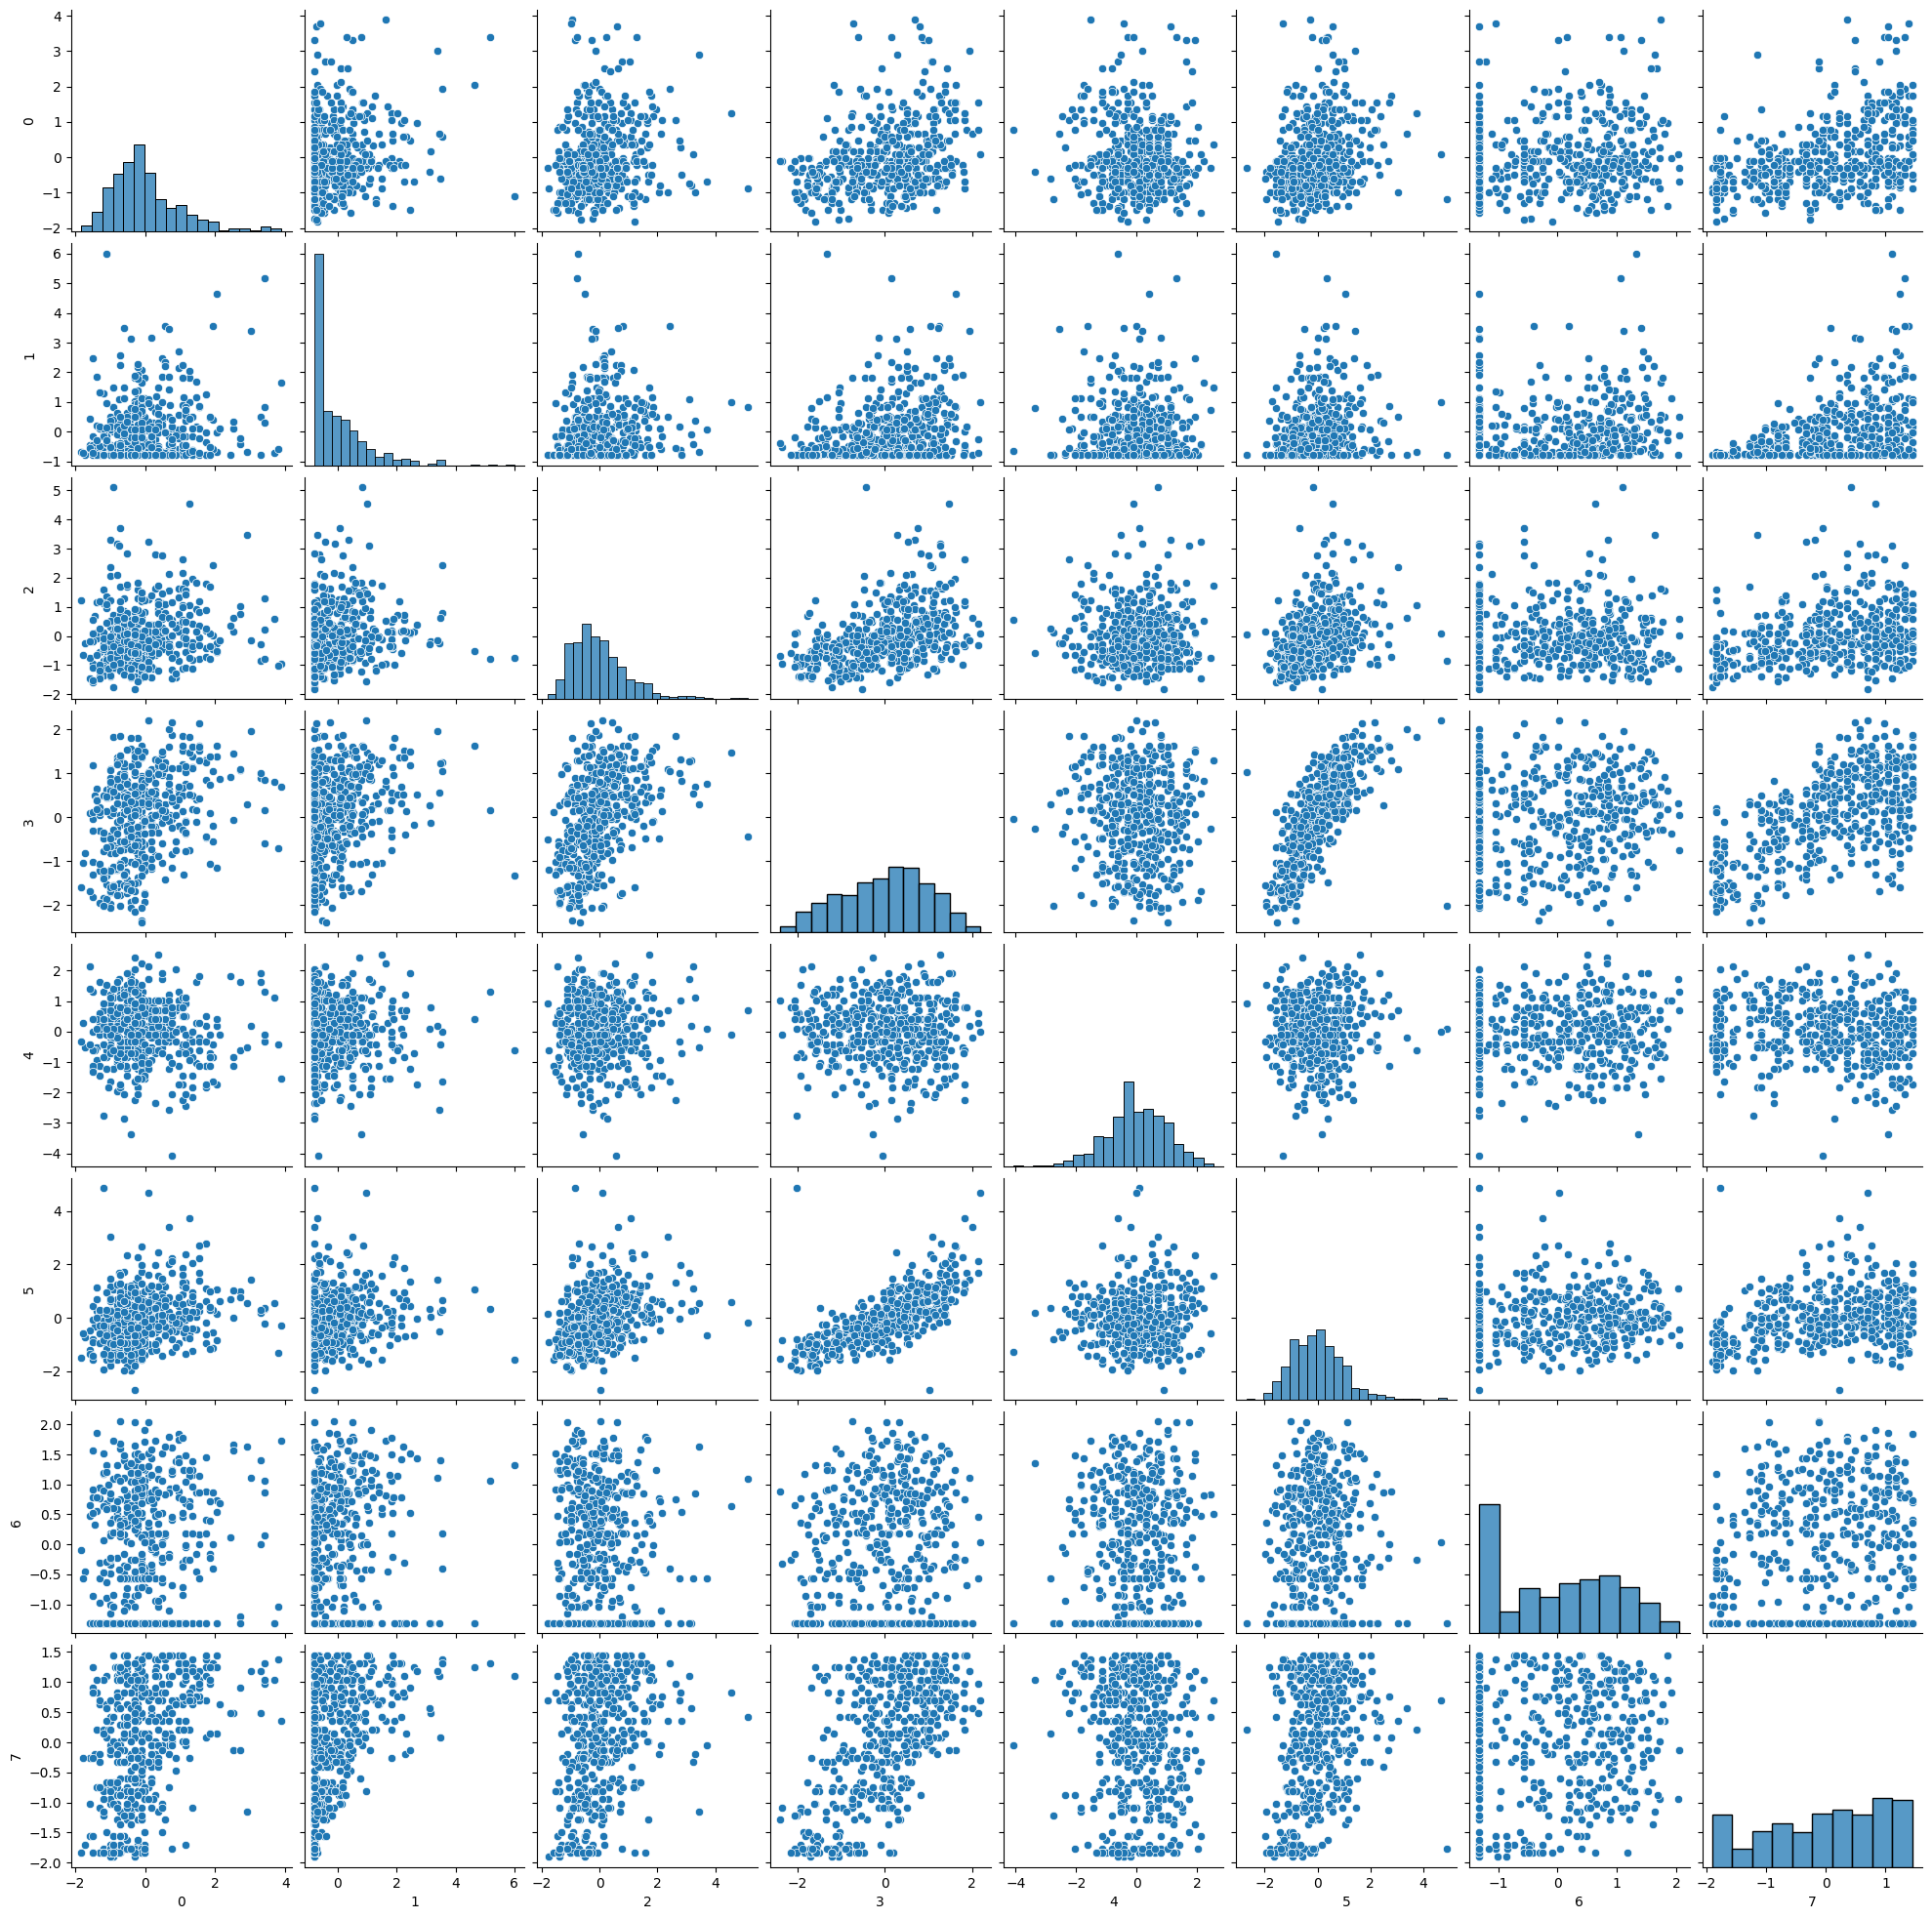

In [18]:
# Create pairplot (scatterplots for all variable combinations)

df = pd.DataFrame(Y)
sns.pairplot(df, diag_kind="hist")  

# Show plot
plt.show()

This is hard to read, it can be used to single out correlations between small groups of attributes.

In [19]:
print(attributeNames_norm)

['normalized sbp', 'normalized tobacco', 'normalized ldl', 'normalized adiposity', 'normalized typea', 'normalized obesity', 'normalized log-alc', 'normalized age', 'normalized famhist']
